# Horse Colic Dataset investigation

## Introduction to the Dataset

The dataset used for this investigation is the Horse Colic dataset from UC Irvine. The data contains a variety of features, both categorical and numerical, and including continuous and discrete numerical values. Each row is a distinct case of colic in a horse, and the outcomes (whether the horse lived, died, or was euthanized as well as whether the colic required surgery) are also included. The data was retrieved from [the UC Irvine Machine Learning datasets archives](https://archive.ics.uci.edu/ml/datasets/Horse+Colic).

## Business Questions

The following questions will be explored via the UC Irvine Horse Colic dataset. Each of these questions is relevant from an exploratory data analysis perspective when seeking to make predictions and decisions about a horse's prognosis and treatment in various colic cases. This topic is of interest and importance to horse owners, trainers, barn managers and veterinarians.

1. What characteristics are most associated with cases in which the colic needed surgery to be treated?
2. What characteristics of the horse's condition were most associated with a "lived" outcome (as opposed to "died" or "was euthanized")?
3. What were some of the ranges of the various health indicator parameters commonly measured by horse owners (such as rectal temperature, heart rate, respiratory rate, capillary refill time, mucous membranes and pain level), by outcome?


## Import Packages

First we must import the necessary packages to begin analyzing the data and answering the business questions listed above.

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call

## Gather

The first step in the CRISP-DM Data Science process is "Gather", so we gather the dataset from UC Irvine by loading it into the notebook. Note that the data has been downloaded and unzipped already.

In [42]:
horse_data = pd.read_csv('./horse-colic-dataset/horse.csv')

## Assess

The next step in the Data Science process is "Assess", so we examine the loaded data to identify categorical features, and missing values.

In [43]:
horse_data.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,...,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,...,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,...,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,...,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [44]:
horse_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
surgery                  299 non-null object
age                      299 non-null object
hospital_number          299 non-null int64
rectal_temp              239 non-null float64
pulse                    275 non-null float64
respiratory_rate         241 non-null float64
temp_of_extremities      243 non-null object
peripheral_pulse         230 non-null object
mucous_membrane          252 non-null object
capillary_refill_time    267 non-null object
pain                     244 non-null object
peristalsis              255 non-null object
abdominal_distention     243 non-null object
nasogastric_tube         195 non-null object
nasogastric_reflux       193 non-null object
nasogastric_reflux_ph    53 non-null float64
rectal_exam_feces        197 non-null object
abdomen                  181 non-null object
packed_cell_volume       270 non-null float64
total_protein            266 non-null

It looks like we have 299 cases to examine, and 27 meaningful features (excluding `hospital_number`, which is more of an id). Of the 27 features, 7 are linear and the rest categorical, including those which are coded numerically, such as `lesion_1`, `lesion_2` and `lesion_3`. Most of the features are missing some values, but only three features are missing more than 40% of the values: `nasogastric_reflux_ph`, `abdomo_appearance` and `abdomo_protein`. The two `abdomo` features are likely missing because of cases where an abdominocentesis was not performed.

## Clean

The third step in this process is to "Clean", at which point we will handle categorical features and missing values.

Given the business questions listed above and the features for which we are missing more than 40% (in one case more than 80%) of the values, we will choose to drop some of the columns, fill in the mean value for missing linear data. NaN values will be ignored by pandas' `get_dummies` function by default, which is desirable here so that we do not inadvertently make predictions based on whether or not a certain feature was missing from the data.

Based on the descriptions of the data offered [here](https://archive.ics.uci.edu/ml/datasets/Horse+Colic), it is clear also that `cp_data` and the `lesion_n` columns are not going to be useful for any of the business questions, since the lesion information is not available until after surgery or autopsy and the pathology data is not included.

For cases without any information in `surgery` or `surgical lesion`, we have no outcome information, so these rows must be dropped.

In [152]:
# Remove unnecessary columns
horse_data_cleaned = horse_data.drop(['lesion_1', 'lesion_2', 'lesion_3',
                                      'nasogastric_reflux_ph', 'abdomo_appearance',
                                      'abdomo_protein', 'hospital_number', 'cp_data'], axis=1)

# Remove rows with no outcome information
horse_data_cleaned = horse_data_cleaned[~horse_data_cleaned['surgery'].isnull() |
                                        ~horse_data_cleaned['outcome'].isnull() |
                                        ~horse_data_cleaned['surgical_lesion'].isnull()]

# Fill in missing numeric values
numeric_cols = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']

for col in numeric_cols:
    horse_data_cleaned[col].fillna(horse_data_cleaned[col].mean(), inplace = True)
  
# One-hot encode categorical columns
categoric_cols = ['age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane',
                  'capillary_refill_time', 'peristalsis', 'abdominal_distention',
                  'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen',
                  'pain']

for col in categoric_cols:
    horse_data_cleaned_dummies = pd.concat([horse_data_cleaned,
                                    pd.get_dummies(horse_data_cleaned[col],
                                                   prefix=col)], axis=1).drop([col],axis=1)
   
# Separate outcome-related columns from features
horse_data_outcomes = horse_data_cleaned_dummies[['surgery', 'outcome', 'surgical_lesion']]    
horse_data_features = horse_data_cleaned_dummies.drop(['surgery', 'outcome', 'surgical_lesion'], axis=1)

# Determine column names for categoric features
categoric_features = [c for c in horse_data_features.columns.values if '_'.join(c.split('_')[:-1]) in categoric_cols]

## Analyze

Next, we will begin to answer the business questions outlined above, by analyzing the cleaned dataset and identifying the relevant features for answering each business question.

### Question 1: What characteristics are most associated with cases in which the colic needed surgery to be treated?

For this question, the relevant features to consider are all of those listed above as numeric or categorical, and the target variable will be whether either the `surgery` column (horses which were treated with surgery) or the `surgical lesion` column (horses whose condition was deemed, during surgery or autopsy, to require surgery) is equal to 'yes'. In the following step, "Model", we will perform classification using these features and this target variable.

In [137]:
horse_q1_features = horse_data_features[numeric_cols + categoric_features]
horse_q1_outcomes = pd.Series((horse_data_outcomes['surgery'] == 'yes')
                              | (horse_data_outcomes['surgical_lesion'] == 'yes'))

### Question 2: What characteristics of the horse's condition were most associated with a "lived" outcome (as opposed to "died" or "was euthanized")?

For this question, we need to consider the same features as in Question 1, but the relevant column is the `outcome` column, encoded as `True` for `outcome == 'lived'` or `False` for either `outcome == 'died'` or `outcome == 'euthanized'`. As in Question 1, we will perform classification using these features and this target variable in the next step of the CRISP-DM process.

In [138]:
horse_q2_features = horse_data_features[numeric_cols + categoric_features]
horse_q2_outcomes = pd.Series(horse_data_outcomes['outcome'] == 'lived')

### Question 3: What were some of the ranges of the various health indicator parameters commonly measured by horse owners (such as rectal temperature, heart rate, respiratory rate, capillary refill time, mucous membranes and pain level)?

For this question, the features we need to consider are specifically the typical health parameters measured by the owner on a regular basis or easily measurable by the owner, such as `pulse` or `respiratory_rate`, and not including features such as `nasogastric_tube`, which would require vet intervention to assess.

Since we are not making predictions based on these features, simply exploring the ranges observed in order to compare with what we know to be healthy ranges, we do not need to identify a target variable for classification.

In [153]:
owner_measured_num = ['rectal_temp', 'pulse', 'respiratory_rate']
owner_measured_cat = ['mucous_membrane', 'capillary_refill_time', 'pain']

horse_q3_features = horse_data_cleaned[owner_measured_num + owner_measured_cat]

## Model

For the "Model" step of the CRISP-DM process, we examine each business question individually and select the appropriate model for answering the question.

### Question 1: Surgery

To answer this question, we can perform a classification based on the features identified in the "Analyze" step and the target feature (whether or not the horse required surgery).

In [170]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(horse_q1_features, horse_q1_outcomes, test_size=0.2)
model = RandomForestClassifier(min_samples_leaf=3, n_estimators=6, max_depth=4, random_state=7)
model.fit(X1_train, Y1_train)

y1_preds = model.predict(X1_test)

acc1 = accuracy_score(Y1_test, y1_preds)

print(acc1)

0.75


### Question 2: Life or Death

To answer this question, we can again perform a classification based on the features identified in the "Analyze" step and the target feature, this time considering two categories ("Died" and "Was Euthanized") as equivalent, since for the purposes of this question, they are.

In [171]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(horse_q2_features, horse_q2_outcomes, test_size=0.2)
model2 = RandomForestClassifier(min_samples_leaf=3, n_estimators=6, max_depth=4, random_state=7)
model2.fit(X2_train, Y2_train)

y2_preds = model2.predict(X2_test)

acc2 = accuracy_score(Y2_test, y2_preds)

print(acc2)

0.733333333333


#### Question 3: Health Parameters

Many horse owners, trainers, barn managers and veterinarians check a particular subset of health parameters for horses, which can indicate colic or other health conditions. It is useful to know what the ranges for these health parameters were in the dataset for colic cases, since these can be compared to healthy ranges, which are pretty well established in the literature.

In [154]:
horse_q3_features.describe()

,rectal_temp,pulse,respiratory_rate
count,299.000000,299.000000,299.000000
mean,38.168619,72.000000,30.460581
std,0.655730,27.468469,15.853977
min,35.400000,30.000000,8.000000
25%,37.900000,48.500000,20.000000
50%,38.168619,68.000000,30.000000
75%,38.500000,88.000000,34.500000
max,40.800000,184.000000,96.000000


## Visualize

For the final step of this data science project, we will examine visualizations for each of the business questions.

### Question 1: Surgery

The following visualization of the model generated above shows the relationship between a variety of parameters and the resolution (surgical or medical) of the colic case.

In [188]:
def plot_tree(estimator, features, class_names, file_name):
    # Export as dot file
    export_graphviz(estimator, out_file=file_name + '.dot', 
                    feature_names = features,
                    class_names = class_names,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png
    call(['dot', '-Tpng', file_name + '.dot', '-o', file_name + '.png', '-Gdpi=600'])

    # Display in python
    plt.figure(figsize = (14, 18))
    plt.imshow(plt.imread(file_name + '.png'))
    plt.axis('off')
    plt.show()

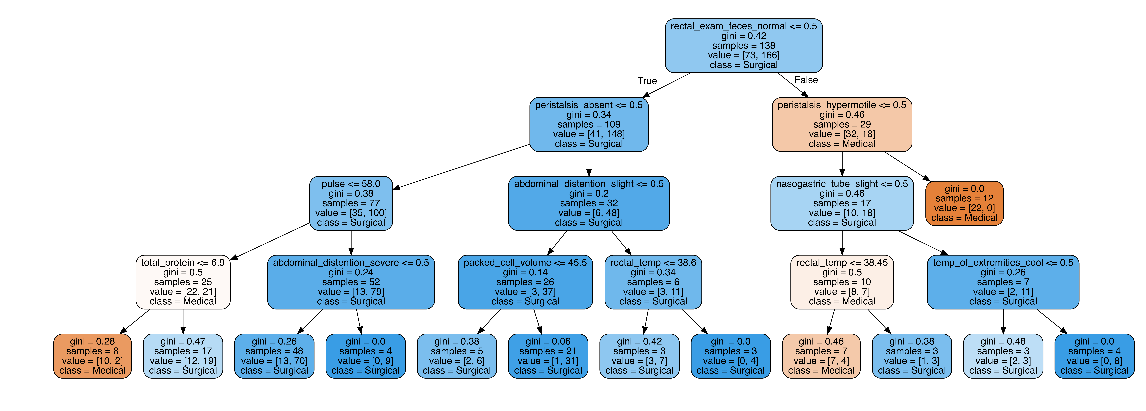

In [189]:
# Extract single tree
estimator = model.estimators_[5]

features = horse_q1_features.columns.values
class_names = ['Medical', 'Surgical']
file_name = 'tree'

plot_tree(estimator, features, class_names, file_name)

### Question 2: Life or Death

The following is a visualization showing the relationship between various parameters and the outcome of the colic case ("Lived" or "Died"/"Was Euthanized").

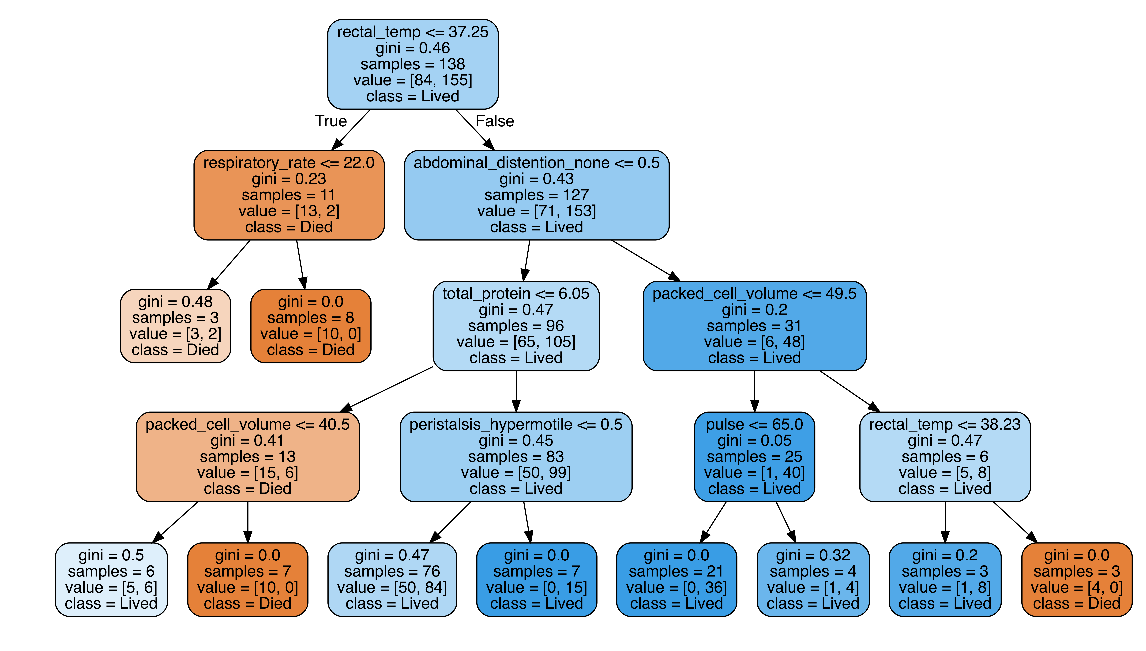

In [190]:
# Extract single tree
estimator2 = model2.estimators_[5]

features2 = horse_q2_features.columns.values
class_names2 = ['Died', 'Lived']
file_name2 = 'tree2'

plot_tree(estimator2, features2, class_names2, file_name2)

### Question 3: Health Parameters

Finally, we include a visualization of the ranges of the various health parameters commonly checked by horse owners and others who come into regular contact with horses.

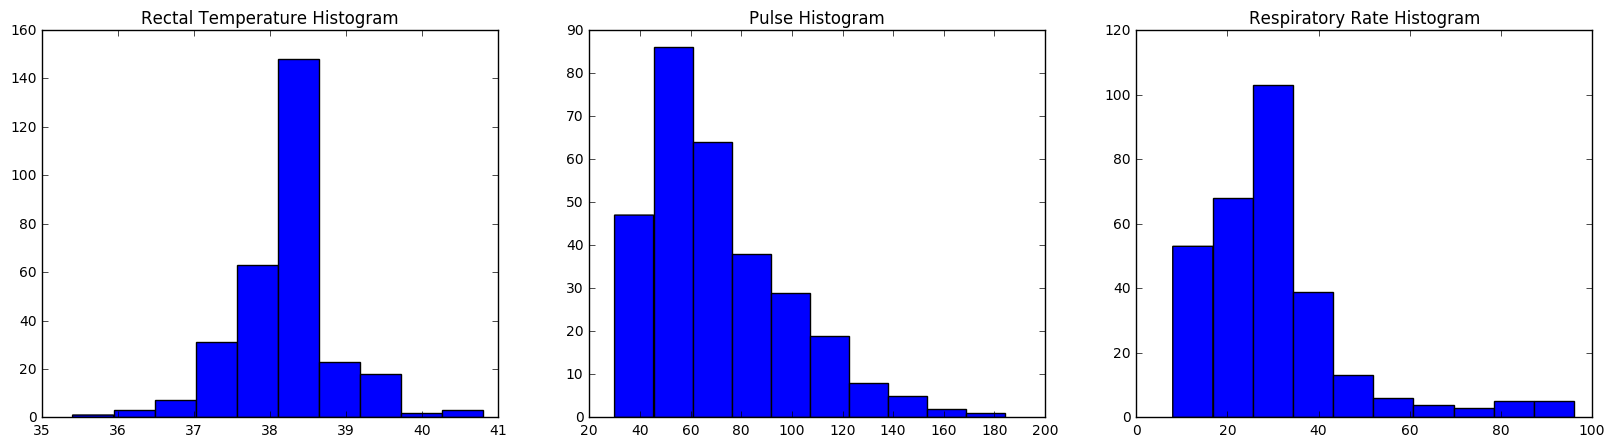

In [151]:
# first plot numeric histograms
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].hist(horse_q3_features.rectal_temp, bins=10)
ax[0].set_title('Rectal Temperature Histogram')
ax[1].hist(horse_q3_features.pulse, bins=10)
ax[1].set_title('Pulse Histogram')
ax[2].hist(horse_q3_features.respiratory_rate, bins=10)
ax[2].set_title('Respiratory Rate Histogram')
plt.show()

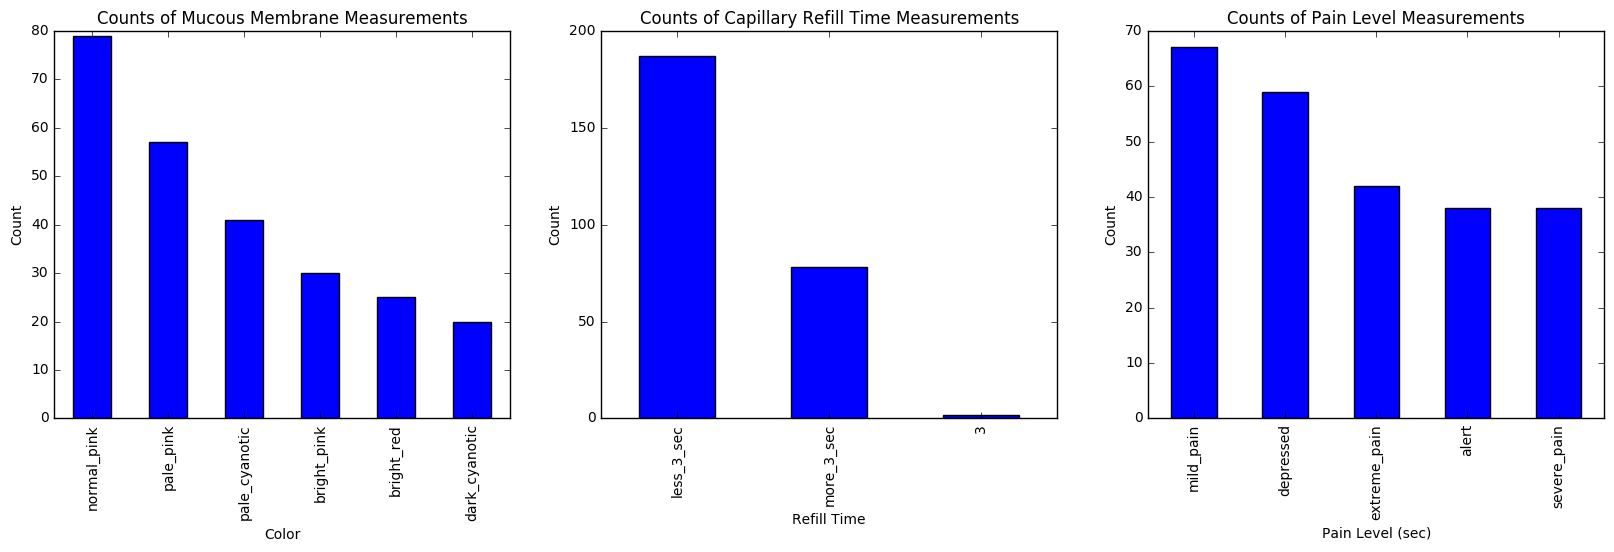

In [162]:
# next plot categorical counts
fig2, ax2 = plt.subplots(1,3, figsize=(20, 5))
horse_q3_features.mucous_membrane.value_counts().plot(ax=ax2[0], kind='bar')
ax2[0].set_xlabel("Color")
ax2[0].set_ylabel("Count")
ax2[0].set_title('Counts of Mucous Membrane Measurements')

horse_q3_features.capillary_refill_time.value_counts().plot(ax=ax2[1], kind='bar')
ax2[1].set_xlabel("Refill Time")
ax2[1].set_ylabel("Count")
ax2[1].set_title('Counts of Capillary Refill Time Measurements')

horse_q3_features.pain.value_counts().plot(ax=ax2[2], kind='bar')
ax2[2].set_xlabel("Pain Level (sec)")
ax2[2].set_ylabel("Count")
ax2[2].set_title('Counts of Pain Level Measurements')
plt.show()

### Acknowledgements

Tree visualization code from [here](https://gist.github.com/WillKoehrsen/ff77f5f308362819805a3defd9495ffd)